# Modelo de rede neural recorrente com long short term memory

In [ ]:
!gdown 1YBUaJ__zGDkAxnSz_0Ah55A98a_cHC0I
!gdown 1WY_A5Xs6y57eqJlaWrb9rJz5zYUPoIOG

Downloading...
From (original): https://drive.google.com/uc?id=1YBUaJ__zGDkAxnSz_0Ah55A98a_cHC0I
From (redirected): https://drive.google.com/uc?id=1YBUaJ__zGDkAxnSz_0Ah55A98a_cHC0I&confirm=t&uuid=9a93665d-5585-4434-904f-4a0ef108bf9a
To: /content/DADOS_PROCESSADOS_VERSAO_3.csv
100% 2.27G/2.27G [00:14<00:00, 157MB/s]
Downloading...
From (original): https://drive.google.com/uc?id=1WY_A5Xs6y57eqJlaWrb9rJz5zYUPoIOG
From (redirected): https://drive.google.com/uc?id=1WY_A5Xs6y57eqJlaWrb9rJz5zYUPoIOG&confirm=t&uuid=327c4aa0-ec6c-4b34-9667-d88ed2fede67
To: /content/DADOS_PROCESSADOS_SPRINT_4.csv
100% 2.95G/2.95G [00:22<00:00, 131MB/s]


Bibliotecas a serem utilizadas no caderno.

In [ ]:
!pip install imbalanced-learn

In [ ]:
import numpy as np
import pandas as pd
import random
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.sequence import pad_sequences #type: ignore
from tensorflow.keras.utils import to_categorical #type: ignore
from tensorflow.keras.models import Sequential #type: ignore
from tensorflow.keras.layers import LSTM, Dense, Embedding, Input, Bidirectional #type: ignore
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.metrics import Precision, Recall
import matplotlib.pyplot as plt
import seaborn as sns
from imblearn.under_sampling import RandomUnderSampler
from collections import Counter

## 01 - Importação do dataset

In [ ]:
df = pd.read_csv('/content/DADOS_PROCESSADOS_SPRINT_4.csv', delimiter=',')
df

,MATRICULA,CONS_MEDIDO,ANOMES,COD_LATITUDE,COD_LONGITUDE,ECO_INDUSTRIAL,ECO_COMERCIAL,ECO_PUBLICA,ECO_OUTRAS,COD_GRUPO,...,mes,ano,verao,outono,inverno,primavera,CATEGORIA_COMERCIAL,CATEGORIA_INDUSTRIAL,CATEGORIA_PUBLICA,CATEGORIA_RESIDENCIAL
0,17000001.0,-0.461538,12021,-20.527506,-54.604682,0.0,0.0,0.0,0.0,7.0,...,1,2021,1,0,0,0,0,0,0,1
1,17000001.0,-0.230769,12022,-20.527506,-54.604682,0.0,0.0,0.0,0.0,7.0,...,1,2022,1,0,0,0,0,0,0,1
2,17000001.0,-0.384615,12023,-20.527506,-54.604682,0.0,0.0,0.0,0.0,7.0,...,1,2023,1,0,0,0,0,0,0,1
3,17000001.0,-0.076923,12024,-20.527506,-54.604682,0.0,0.0,0.0,0.0,7.0,...,1,2024,1,0,0,0,0,0,0,1
4,17000001.0,-0.384615,22021,-20.527506,-54.604682,0.0,0.0,0.0,0.0,7.0,...,2,2021,1,0,0,0,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
20615607,17997640.0,-0.230769,72024,-20.391947,-54.610908,0.0,0.0,0.0,0.0,21.0,...,7,2024,0,0,1,0,0,0,0,1
20615608,17997641.0,0.153846,72024,-20.392116,-54.610830,0.0,0.0,0.0,0.0,21.0,...,7,2024,0,0,1,0,0,0,0,1
20615609,17997645.0,-0.538462,72024,-20.500207,-54.690632,0.0,0.0,0.0,0.0,19.0,...,7,2024,0,0,1,0,0,0,0,1
20615610,17997650.0,-0.538462,82024,-20.442358,-54.593146,0.0,0.0,0.0,0.0,6.0,...,8,2024,0,0,1,0,0,0,0,1


In [ ]:
# Converter a coluna 'MATRICULA' para inteiro
df['MATRICULA'] = df['MATRICULA'].astype(int)

# Atualizar a coluna 'FRAUDADOR' de forma que, se uma matrícula tem fraude (FRAUDADOR=1),
# todas as linhas dessa matrícula também terão FRAUDADOR=1
df['FRAUDADOR'] = df.groupby('MATRICULA')['FRAUDADOR'].transform(max)

# Verificar se a transformação foi aplicada corretamente
df[['MATRICULA', 'FRAUDADOR']]

<ipython-input-32-dfc20774c366>:6: FutureWarning: The provided callable <built-in function max> is currently using SeriesGroupBy.max. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "max" instead.
  df['FRAUDADOR'] = df.groupby('MATRICULA')['FRAUDADOR'].transform(max)


,MATRICULA,FRAUDADOR
0,17000001,0
1,17000001,0
2,17000001,0
3,17000001,0
4,17000001,0
...,...,...
20615607,17997640,1
20615608,17997641,1
20615609,17997645,0
20615610,17997650,0


In [ ]:
# Identificar todas as matrículas que possuem fraude (FRAUDADOR == 1)
matriculas_fraudadoras = df[df['FRAUDADOR'] == 1]['MATRICULA'].unique()

# Atualizar a coluna FRAUDADOR para 1 em todas as linhas que possuem as mesmas matrículas
df.loc[df['MATRICULA'].isin(matriculas_fraudadoras), 'FRAUDADOR'] = 1

# Visualizar o dataframe atualizado
df

,MATRICULA,CONS_MEDIDO,ANOMES,COD_LATITUDE,COD_LONGITUDE,ECO_INDUSTRIAL,ECO_COMERCIAL,ECO_PUBLICA,ECO_OUTRAS,COD_GRUPO,...,mes,ano,verao,outono,inverno,primavera,CATEGORIA_COMERCIAL,CATEGORIA_INDUSTRIAL,CATEGORIA_PUBLICA,CATEGORIA_RESIDENCIAL
0,17000001,-0.461538,12021,-20.527506,-54.604682,0.0,0.0,0.0,0.0,7.0,...,1,2021,1,0,0,0,0,0,0,1
1,17000001,-0.230769,12022,-20.527506,-54.604682,0.0,0.0,0.0,0.0,7.0,...,1,2022,1,0,0,0,0,0,0,1
2,17000001,-0.384615,12023,-20.527506,-54.604682,0.0,0.0,0.0,0.0,7.0,...,1,2023,1,0,0,0,0,0,0,1
3,17000001,-0.076923,12024,-20.527506,-54.604682,0.0,0.0,0.0,0.0,7.0,...,1,2024,1,0,0,0,0,0,0,1
4,17000001,-0.384615,22021,-20.527506,-54.604682,0.0,0.0,0.0,0.0,7.0,...,2,2021,1,0,0,0,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
20615607,17997640,-0.230769,72024,-20.391947,-54.610908,0.0,0.0,0.0,0.0,21.0,...,7,2024,0,0,1,0,0,0,0,1
20615608,17997641,0.153846,72024,-20.392116,-54.610830,0.0,0.0,0.0,0.0,21.0,...,7,2024,0,0,1,0,0,0,0,1
20615609,17997645,-0.538462,72024,-20.500207,-54.690632,0.0,0.0,0.0,0.0,19.0,...,7,2024,0,0,1,0,0,0,0,1
20615610,17997650,-0.538462,82024,-20.442358,-54.593146,0.0,0.0,0.0,0.0,6.0,...,8,2024,0,0,1,0,0,0,0,1


In [ ]:
# Contar a quantidade de dados com FRAUDADOR = 1 e FRAUDADOR = 0
fraudador_counts = df['FRAUDADOR'].value_counts()

# Exibir o resultado
print(f"Quantidade de dados com FRAUDADOR = 1: {fraudador_counts.get(1, 0)}")
print(f"Quantidade de dados com FRAUDADOR = 0: {fraudador_counts.get(0, 0)}")

Quantidade de dados com FRAUDADOR = 1: 9661160
Quantidade de dados com FRAUDADOR = 0: 10954452


<ipython-input-37-c4cf1be31625>:43: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=list(class_counts_after.keys()), y=list(class_counts_after.values()), palette='viridis')
/usr/local/lib/python3.10/dist-packages/seaborn/_base.py:949: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/usr/local/lib/python3.10/dist-packages/seaborn/_base.py:949: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)


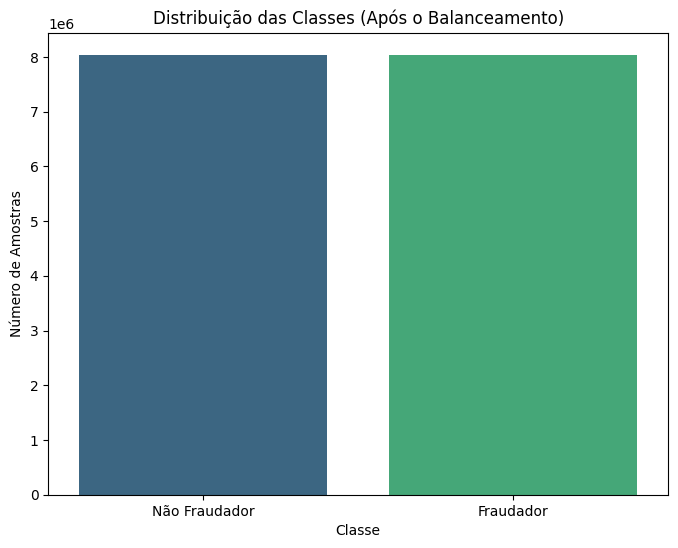

Formato dos dados de entrada (X): (13017635, 8, 17)
Formato dos dados de saída (y): (13017635,)


In [ ]:
# Salvar os dados do ano de 2024 em um arquivo CSV
df_2024 = df[df['ano'] == 2024]
df_2024.to_csv('/content/dados_2024.csv', index=False)

# Remover os dados do ano de 2024 para treino
df = df[df['ano'] < 2024]

# Identificar todas as matrículas que possuem fraude (FRAUDADOR == 1)
matriculas_fraudadoras = df[df['FRAUDADOR'] == 1]['MATRICULA'].unique()

# Atualizar a coluna FRAUDADOR para 1 em todas as linhas que possuem as mesmas matrículas
df.loc[df['MATRICULA'].isin(matriculas_fraudadoras), 'FRAUDADOR'] = 1

# Balanceamento dos dados: remover registros não fraudulentos até que as classes fiquem balanceadas
fraudadores = df[df['FRAUDADOR'] == 1]
nao_fraudadores = df[df['FRAUDADOR'] == 0].sample(n=len(fraudadores), random_state=42)

# Concatenar os dados balanceados
df_balanced = pd.concat([fraudadores, nao_fraudadores])

# Ordenar os dados por matrícula, ano e mês para manter a integridade temporal
df_balanced = df_balanced.sort_values(by=['MATRICULA', 'ano', 'mes'])

# Selecionar as colunas que serão usadas no modelo
features = ['verao', 'outono', 'inverno', 'primavera', 'CONS_MEDIDO',
            'CATEGORIA_COMERCIAL', 'CATEGORIA_INDUSTRIAL',
            'CATEGORIA_PUBLICA', 'CATEGORIA_RESIDENCIAL',
            'QUADRANT_1', 'QUADRANT_2', 'QUADRANT_3',
            'QUADRANT_4', 'QUADRANT_5', 'QUADRANT_6',
            'QUADRANT_7', 'QUADRANT_8']

target = 'FRAUDADOR'

# Separar as features e o target
X = df_balanced[features].values
y = df_balanced[target].values

# Verificar a distribuição das classes após o balanceamento
class_counts_after = Counter(y)

# Criar o gráfico de distribuição após o balanceamento
plt.figure(figsize=(8, 6))
sns.barplot(x=list(class_counts_after.keys()), y=list(class_counts_after.values()), palette='viridis')
plt.title('Distribuição das Classes (Após o Balanceamento)')
plt.xlabel('Classe')
plt.ylabel('Número de Amostras')
plt.xticks(ticks=[0, 1], labels=['Não Fraudador', 'Fraudador'])
plt.show()

n_passos = 8

# Função para criar sequências temporais para o LSTM
def criar_sequencias(dados, alvo, n_passos):
    X_seq, y_seq = [], []
    for i in range(len(dados) - n_passos):
        X_seq.append(dados[i:i + n_passos])  # Dados de entrada (X)
        y_seq.append(alvo[i + n_passos])  # Dados alvo (y) - prevendo FRAUDADOR
    return np.array(X_seq), np.array(y_seq)

# Criar uma estrutura para armazenar os dados
X_list = []
y_list = []

# Agrupar por matrícula e criar as sequências temporais
for matricula, group in df_balanced.groupby('MATRICULA'):
    dados = group[features].values  # Obter os dados para aquela matrícula (apenas features)
    alvo = group['FRAUDADOR'].values  # Obter a coluna 'FRAUDADOR' como alvo

    # Garantir que há sequências suficientes para criar uma janela temporal de n_passos
    if len(dados) > n_passos:
        X, y = criar_sequencias(dados, alvo, n_passos)  # Criar as sequências
        if len(X) > 0:  # Verificar se há sequências criadas
            X_list.append(X)
            y_list.append(y)

# Concatenar os arrays, descartando sequências curtas
if len(X_list) > 0 and len(y_list) > 0:
    X_final = np.concatenate(X_list, axis=0)
    y_final = np.concatenate(y_list, axis=0)

    # Exibir as formas dos dados
    print(f'Formato dos dados de entrada (X): {X_final.shape}')
    print(f'Formato dos dados de saída (y): {y_final.shape}')
else:
    print("Nenhuma sequência válida foi gerada.")

## 03 - Arquitetura da Rede e Treino do Modelo

### GRU

In [ ]:
import numpy as np
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import GRU, Dense, Input, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.metrics import Precision, Recall, AUC
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

# Definir o número de features e o comprimento da sequência com base nos dados
n_features = X_final.shape[2]  # Número de features
sequence_length = X_final.shape[1]  # Comprimento da sequência (tamanho da janela temporal)

In [ ]:
# Função para criar o modelo
def create_model():
    model = Sequential()
    model.add(Input(shape=(sequence_length, n_features)))
    model.add(GRU(units=270, return_sequences=True))
    model.add(GRU(units=90, return_sequences=True))
    model.add(GRU(units=30, return_sequences=True))
    model.add(GRU(units=10))
    model.add(Dense(1, activation="sigmoid"))  # Classificação binária

    # Compilar o modelo com as métricas
    model.compile(optimizer=Adam(learning_rate=0.001),
                  loss='binary_crossentropy',
                  metrics=['accuracy', Precision(), Recall(), AUC()])
    return model

# Dividir os dados em treino e validação (80% treino, 20% validação)
X_train, X_val, y_train, y_val = train_test_split(X_final, y_final, test_size=0.3, random_state=42)

# Criar o modelo
model = create_model()

In [ ]:
# Early stopping para parar o treinamento se não houver melhora
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

# Treinar o modelo
history = model.fit(X_train, y_train, epochs=30, batch_size=512, validation_data=(X_val, y_val), callbacks=[early_stopping])

# Avaliar o modelo no conjunto de validação
val_loss, val_accuracy, val_precision, val_recall, val_auc = model.evaluate(X_val, y_val)
f1_score = 2 * (val_precision * val_recall) / (val_precision + val_recall)

# Exibir os resultados
print(f"Validation Loss: {val_loss:.4f}")
print(f"Validation Accuracy: {val_accuracy:.4f}")
print(f"Validation Precision: {val_precision:.4f}")
print(f"Validation Recall: {val_recall:.4f}")
print(f"Validation AUC: {val_auc:.4f}")
print(f"Validation F1 Score: {f1_score:.4f}")

# Fazer previsões no conjunto de validação
y_pred = (model.predict(X_val) > 0.5).astype("int32")

# Gerar a matriz de confusão
cm = confusion_matrix(y_val, y_pred)

# Plotar a matriz de confusão
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(cmap=plt.cm.Blues)
plt.title("Matriz de Confusão")
plt.show()

Epoch 1/30
17798/17798 [==============================] - 1851s 104ms/step - loss: 0.2824 - accuracy: 0.8349 - precision_3: 0.9755 - recall_3: 0.7133 - auc_3: 0.9242 - val_loss: 0.2779 - val_accuracy: 0.8380 - val_precision_3: 0.9489 - val_recall_3: 0.7408 - val_auc_3: 0.9288
Epoch 2/30
17798/17798 [==============================] - 1836s 103ms/step - loss: 0.2767 - accuracy: 0.8390 - precision_3: 0.9593 - recall_3: 0.7340 - auc_3: 0.9296 - val_loss: 0.2767 - val_accuracy: 0.8389 - val_precision_3: 0.9697 - val_recall_3: 0.7253 - val_auc_3: 0.9301
Epoch 3/30
17798/17798 [==============================] - 1836s 103ms/step - loss: 0.2761 - accuracy: 0.8395 - precision_3: 0.9583 - recall_3: 0.7359 - auc_3: 0.9303 - val_loss: 0.2762 - val_accuracy: 0.8394 - val_precision_3: 0.9591 - val_recall_3: 0.7349 - val_auc_3: 0.9306
Epoch 4/30
17798/17798 [==============================] - 1835s 103ms/step - loss: 0.2757 - accuracy: 0.8399 - precision_3: 0.9576 - recall_3: 0.7371 - auc_3: 0.9307 - v

In [ ]:
# Função para plotar as métricas de validação ao longo das épocas
def plot_metric(history, metric):
    plt.figure(figsize=(8, 6))
    plt.plot(history.history[metric], label=f'{metric.capitalize()} (Treino)')
    plt.plot(history.history[f'val_{metric}'], label=f'{metric.capitalize()} (Validação)')
    plt.title(f'{metric.capitalize()} ao longo das Épocas')
    plt.xlabel('Épocas')
    plt.ylabel(metric.capitalize())
    plt.legend()
    plt.grid(True)
    plt.show()

# Plotar as métricas disponíveis (ajustar os nomes para os que estão no histórico)
#plot_metric(history, 'auc_7')      # Gráfico de AUC
plot_metric(history, 'loss')       # Gráfico de Loss
plot_metric(history, 'accuracy')   # Gráfico de Acurácia
#plot_metric(history, 'precision_15')  # Gráfico de Precision
#plot_metric(history, 'recall_15')  # Gráfico de Recall


In [ ]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# Supondo que as variáveis y_val (valores reais) e y_pred (valores preditos) já existam:
# Criar a matriz de confusão
cm = confusion_matrix(y_val, y_pred)

# Plotar a matriz de confusão
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(cmap=plt.cm.Blues)
plt.title("Matriz de Confusão")
plt.show()

In [ ]:
# Dividir em conjuntos de treinamento e teste
X_train, X_test, y_train, y_test = train_test_split(X_final, y_final, test_size=0.2, random_state=42)

# Converter as sequências e alvos em arrays numpy
X_train = np.array(X_train)
X_test = np.array(X_test)

In [ ]:
import pandas as pd
import pickle

# Carregar o arquivo HDF5
h5_filepath = 'caminho/para/seu_arquivo.h5'
df = pd.read_hdf(h5_filepath)

# Salvar como arquivo pickle
df_pkl_filepath = 'caminho/para/seu_arquivo_df.pkl'
df.to_pickle(df_pkl_filepath)

print(f'Arquivo DataFrame convertido e salvo em: {df_pkl_filepath}')

# Salvar um modelo treinado como pickle
modelo_treinado = 'seu_modelo_treinado'
model_pkl_filepath = 'caminho/para/seu_modelo.pkl'
with open(model_pkl_filepath, 'wb') as model_file:
    pickle.dump(modelo_treinado, model_file)

print(f'Modelo treinado salvo em: {model_pkl_filepath}')

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(
